In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
import numpy as np
import pandas as pd
from qutip import *
warnings.filterwarnings('ignore')
from itertools import product
import plotly.express as px
from scipy.optimize import minimize_scalar
from scipy.signal import argrelextrema

## SJB code

In [450]:
E = 1.0                   # two level energy difference
N = 11                    # number of phonon quanta needed to exite the atom
E_phonon = E / N          # phonon energy
M_min =  1000             # Min mode number to simulation
M_max =  1300             # Max mode number to simulation
ng = 500                  # number of different coupling strengths to try out (need 100 to reproduce SJByrnes Moiré pattern)
min_coupling = 0.006*E    # min atom phonon coupling
max_coupling = 0.03*E     # maximum atom phonon coupling
parity = "even"           # "all", "even" or "odd"

M = M_max - M_min                           # Number of modes to simulate
num_states = 2*M if parity=="all" else M    # Number of states needed to represent the system

In [424]:
a  = tensor(destroy(M,M_min), qeye(2))     # phonon destruction operator
sm = tensor(qeye(M), sigmam())             # sigma_minus operator which is often called a lowering operator
sz = tensor(qeye(M),sigmaz())              # z component of the "spin" of the two level system

two_state     =  E*sz/2                         # two state system energy
phonons       =  E_phonon*(a.dag()*a+0.5)       # phonon field energy
interaction   = (a.dag() + a) * (sm + sm.dag()) # interaction energy - needs to be multiplied by coupling constant in final H

In [425]:
#inspired by SJB code https://github.com/sbyrnes321/cf/blob/1a34a461c3b15e26cad3a15de3402142b07422d9/spinboson.py#L56
if parity != "all":
    S=1/2
    possible_ns = range(M_min, M_max)
    possible_ms = - (np.arange(2*S+1) - S)
    Smn_list = product([S], possible_ns, possible_ms)

    if parity == "even":
        mn_from_index = [(n-M_min,int(np.abs(m-0.5))) for (S,n,m) in Smn_list if (S+m+n) % 2 == 0]
    elif parity == "odd":
        mn_from_index = [(n-M_min,int(np.abs(m-0.5))) for (S,n,m) in Smn_list if (S+m+n) % 2 == 1]

    subset_idx = []
    for s in mn_from_index:
        subset_idx.append(state_number_index([M,2],s))
    
    # Labels for hinton plots in case we want to plot it later (use xlabels=ket_labels, ylabels = bra_labels)
    bra_labels = ["$\langle$"+str(n)+", "+str(m)+"|" for (n,m) in mn_from_index]
    ket_labels = ["|"+str(n)+", "+str(m)+"$\\rangle$" for (n,m) in mn_from_index]


    # http://qutip.org/docs/latest/apidoc/classes.html?highlight=extract_states#qutip.Qobj.extract_states
    two_state    = two_state.extract_states(subset_idx) 
    phonons      = phonons.extract_states(subset_idx) 
    interaction  = interaction.extract_states(subset_idx) 
    
    

In [426]:
d = {"coupling":np.linspace(0,max_coupling,ng)}
for i in range(num_states):
    d[f"level_{i}"] = np.zeros(ng)
    
df = pd.DataFrame(data=d)

In [427]:
for index, row in df.iterrows():
    # c.f. https://coldfusionblog.net/2017/07/09/numerical-spin-boson-model-part-1/
    H = two_state + phonons + row.coupling*interaction
    evals, ekets = H.eigenstates()
    df.iloc[index,1:] = np.real(evals/E_phonon)
    

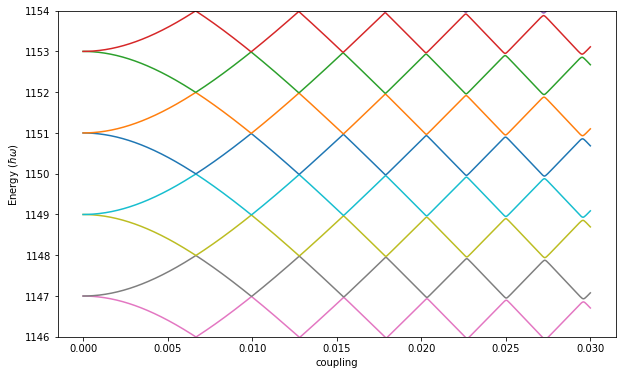

In [428]:
df.plot(x="coupling",ylim=[1146,1154],figsize=(10,6),legend=False);
plt.ylabel("Energy ($\hbar\omega$)");


# It can be easier to initially explore with an interactive plot like the one below (it does take more memory though).
# melt = df.melt(id_vars=["coupling"],var_name="level",value_name="energy")
# fig = px.line(melt,x="coupling",y="energy",color="level",width=900,height=600)
# fig.layout.showlegend = False 
# fig.show()

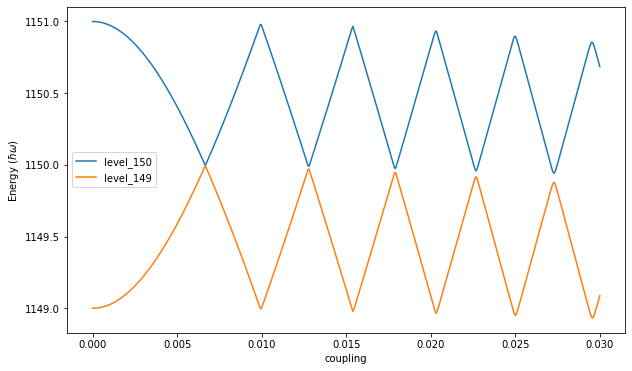

In [429]:
df[["coupling","level_150","level_149"]].plot(x="coupling",figsize=(10,6));
plt.ylabel("Energy ($\hbar\omega$)");

## Let's look at the energy difference between the levels

In [430]:
df_diff = df.drop('coupling', axis=1).diff(axis=1).dropna(axis=1)
df_diff["coupling"] = df["coupling"]

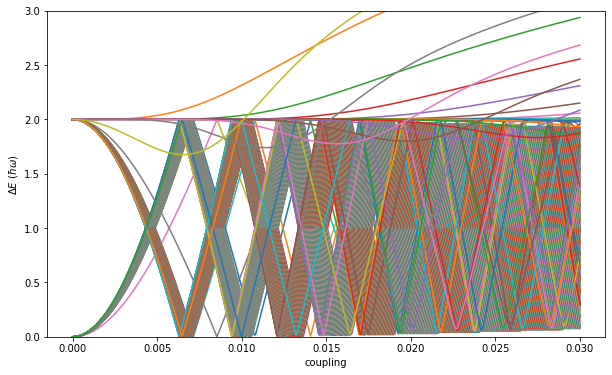

In [431]:
df_diff.plot(x="coupling",ylim=[0,3],figsize=(10,6),legend=False);
plt.ylabel("$\Delta E$ ($\hbar\omega$)");

# It can be easier to initially explore with an interactive plot like the one below (it does take more memory though).
# melt_diff = df_diff.melt(id_vars=["coupling"],var_name="level",value_name="energy")
# fig = px.line(melt_diff,x="coupling",y="energy",color="level",width=900,height=600)
# fig.layout.showlegend = False 
# fig.show()

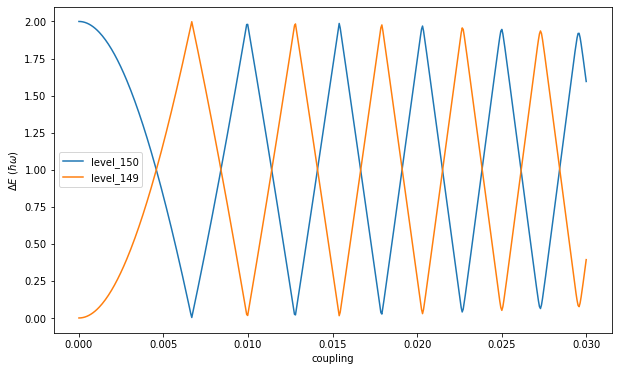

In [432]:
df_diff[["coupling","level_150","level_149"]].plot(x="coupling",figsize=(10,6));
plt.ylabel("$\Delta E$ ($\hbar\omega$)");

# Let's try and make of plot $\delta E_{min}$ vs coupling like Peter did

To make a plot like Peters in his 2008 paper we essentially have to track the multiple minima you see in the above graphs.

SJB does this by [tracking energy eigenvalues number 50 and 51](https://github.com/sbyrnes321/cf/blob/1a34a461c3b15e26cad3a15de3402142b07422d9/spinboson.py#L265). He tracks this by using `minimize_scalar` to find the precise mins. For now, I'll use `argrelextrema` to find the multiple min points automatically.

In [433]:
df_diff_subset = df_diff[["coupling","level_150","level_149"]]

In [434]:
df_diff_subset["min"] =  df_diff_subset[["level_150","level_149"]].min(axis=1)

In [435]:
df_diff_subset["level_min"] = df_diff_subset[["level_150","level_149"]].idxmin(axis=1).str.split("_",expand = True)[1]

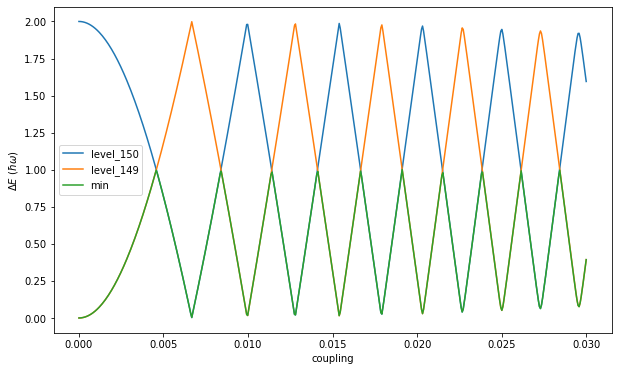

In [436]:
df_diff_subset[["coupling","level_150","level_149","min"]].plot(x="coupling",figsize=(10,6));
plt.ylabel("$\Delta E$ ($\hbar\omega$)");

In [437]:
argmin = argrelextrema(df_diff_subset["min"].values, np.less)[0]
anti_crossing = df_diff_subset.iloc[argmin][["coupling","min","level_min"]]
anti_crossing["g"] = anti_crossing["coupling"]*np.sqrt((M_min+M_max)/2)
anti_crossing.reset_index(inplace=True,drop=True)

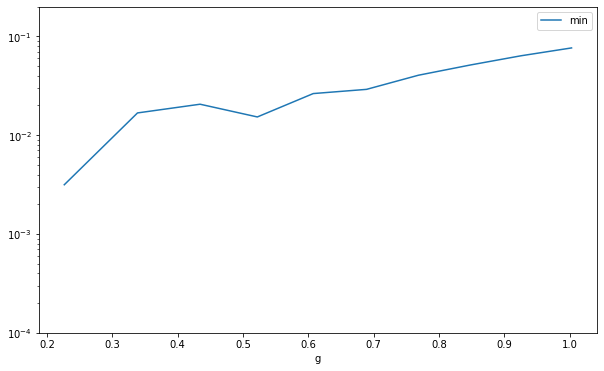

In [438]:
anti_crossing.plot.line(x="g",y="min",logy=True,figsize=(10,6),ylim=[0.0001,0.2]);

In [439]:
def ev(g,i):
    H = two_state + phonons + g*interaction
    evals, ekets = H.eigenstates()
    return evals[i] - evals[i-1] 

In [452]:
dg = (max_coupling - min_coupling)/ng

In [453]:
for index, row in poo.iterrows():
    res = minimize_scalar(ev,args=int(row["level_min"]),bracket=[row["coupling"]-dg, row["coupling"]+dg])
    anti_crossing.loc[index, "coupling"] = res.x
    anti_crossing.loc[index, "min"] = res.fun
anti_crossing["g"] = anti_crossing["coupling"]*np.sqrt((M_min+M_max)/2)

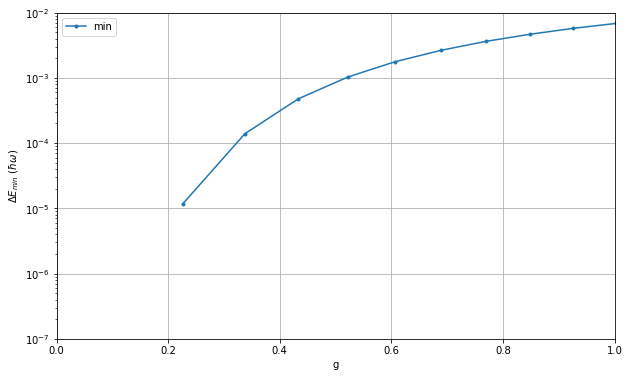

In [469]:
anti_crossing.plot.line(x="g",y="min",logy=True,figsize=(10,6), ylim=[1e-7,1e-2], xlim=[0,1],grid=True,marker=".");
plt.ylabel("$\Delta E_{min}$ ($\hbar\omega$)");

## Investigating phonon number

In [455]:
num = (a.dag()*a).extract_states(subset_idx)

In [456]:
d = {"coupling":np.linspace(0,max_coupling,ng)}
for i in range(num_states):
    d[f"level_{i}"] = np.zeros(ng)
    
df_num = pd.DataFrame(data=d)

In [457]:
for index, row in df_num.iterrows():
    # c.f. https://coldfusionblog.net/2017/07/09/numerical-spin-boson-model-part-1/
    H = two_state + phonons + row.coupling*interaction
    evals, ekets = H.eigenstates()
    df_num.iloc[index,1:] = expect(num,ekets)
    

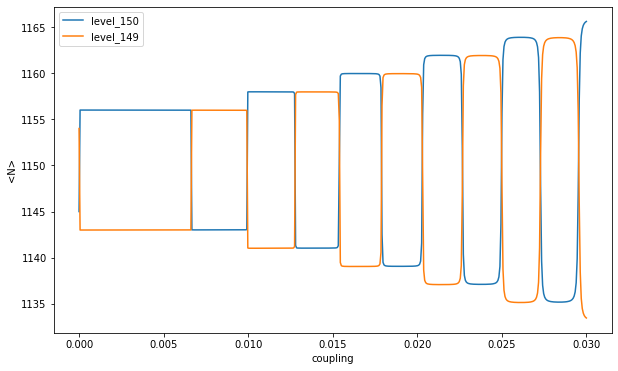

In [470]:
df_num[["coupling","level_150","level_149"]].plot(x="coupling",figsize=(10,6));
plt.ylabel("<N>");